# 优化数据处理

`Linux` `Ascend` `GPU` `CPU` `数据准备` `中级` `高级`

[![](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/_static/logo_source.png)](https://gitee.com/mindspore/docs/blob/master/tutorials/training/source_zh_cn/advanced_use/optimize_data_processing.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/_static/logo_notebook.png)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/optimize_the_performance_of_data_preparation/mindspore_optimize_the_performance_of_data_preparation.ipynb)&emsp;[![](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/_static/logo_modelarts.png)](https://console.huaweicloud.com/modelarts/?region=cn-north-4#/notebook/loading?share-url-b64=aHR0cHM6Ly9vYnMuZHVhbHN0YWNrLmNuLW5vcnRoLTQubXlodWF3ZWljbG91ZC5jb20vbWluZHNwb3JlLXdlYnNpdGUvbm90ZWJvb2svbW9kZWxhcnRzL21pbmRzcG9yZV9vcHRpbWl6ZV90aGVfcGVyZm9ybWFuY2Vfb2ZfZGF0YV9wcmVwYXJhdGlvbi5pcHluYg==&image_id=65f636a0-56cf-49df-b941-7d2a07ba8c8c)

## 概述

数据是整个深度学习中最重要的一环，因为数据的好坏决定了最终结果的上限，模型的好坏只是去无限逼近这个上限，所以高质量的数据输入，会在整个深度神经网络中起到积极作用，数据在整个数据处理和数据增强的过程像经过pipeline管道的水一样，源源不断地流向训练系统，如图所示：

![pipeline](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/advanced_use/images/pipeline.png)

MindSpore为用户提供了数据处理以及数据增强的功能，在数据的整个pipeline过程中，其中的每一步骤，如果都能够进行合理的运用，那么数据的性能会得到很大的优化和提升。本次体验将基于CIFAR-10数据集来为大家展示如何在数据加载、数据处理和数据增强的过程中进行性能的优化。

此外，操作系统的存储、架构和计算资源也会一定程度上影响数据处理的性能。

## 准备环节

### 导入模块

`dataset`模块提供API用来加载和处理数据集。

In [1]:
import mindspore.dataset as ds

`numpy`模块用于生成ndarray数组。

In [2]:
import numpy as np

### 下载所需数据集

运行以下命令来获取数据集：

下载CIFAR-10二进制格式数据集，并将数据集文件解压到`./datasets/cifar10`目录下，数据加载的时候使用该数据集。

In [3]:
!wget -N https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/datasets/cifar10.zip
!unzip -o cifar10.zip -d ./datasets
!tree ./datasets/cifar10

./datasets/cifar10
├── test
│   └── test_batch.bin
└── train
    ├── batches.meta.txt
    ├── data_batch_1.bin
    ├── data_batch_2.bin
    ├── data_batch_3.bin
    ├── data_batch_4.bin
    └── data_batch_5.bin

2 directories, 7 files


下载CIFAR-10 Python文件格式数据集，并将数据集文件解压到`./datasets/cifar-10-batches-py`目录下，数据转换的时候使用该数据集。

In [4]:
!wget -N https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/datasets/cifar10-py.zip
!unzip -o cifar10-py.zip -d ./datasets
!tree ./datasets/cifar-10-batches-py

./datasets/cifar-10-batches-py
├── batches.meta
├── data_batch_1
├── data_batch_2
├── data_batch_3
├── data_batch_4
├── data_batch_5
├── readme.html
└── test_batch

0 directories, 8 files


## 数据加载性能优化

MindSpore为用户提供了多种数据加载方式，其中包括常用数据集加载、用户自定义数据集加载、MindSpore数据格式加载，详情内容请参考[数据集加载](https://www.mindspore.cn/doc/programming_guide/zh-CN/master/dataset_loading.html)。对于数据集加载，底层实现方式的不同，会导致数据集加载的性能存在差异，如下所示：

|      | 常用数据集 | 用户自定义 | MindRecord |
| :----: | :----: | :----: | :----: |
| 底层实现 | C++ | Python | C++ |
| 性能 | 高 | 中 | 高|

### 性能优化方案

![data-loading-performance-scheme](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/advanced_use/images/data_loading_performance_scheme.png)

数据加载性能优化建议如下：

- 已经支持的数据集格式优选内置加载算子，具体内容请参考[内置加载算子](https://www.mindspore.cn/doc/api_python/zh-CN/master/mindspore/mindspore.dataset.html)，如果性能仍无法满足需求，则可采取多线程并发方案，请参考本文[多线程优化方案](#多线程优化方案)。

- 不支持的数据集格式，优选转换为MindSpore数据格式后再使用`MindDataset`类进行加载，具体内容请参考[将数据集转换为MindSpore数据格式](https://www.mindspore.cn/tutorial/training/zh-CN/master/advanced_use/convert_dataset.html)，如果性能仍无法满足需求，则可采取多线程并发方案，请参考本文[多线程优化方案](#多线程优化方案)。

- 不支持的数据集格式，算法快速验证场景，优选用户自定义`GeneratorDataset`类实现，如果性能仍无法满足需求，则可采取多进程并发方案，请参考本文[多进程优化方案](#多进程优化方案)。

### 代码示例

基于以上的数据加载性能优化建议，本次体验分别使用内置加载算子`Cifar10Dataset`类、数据转换后使用`MindDataset`类、使用`GeneratorDataset`类进行数据加载，代码演示如下：

1. 使用内置算子`Cifar10Dataset`类加载CIFAR-10数据集，这里使用的是CIFAR-10二进制格式的数据集，加载数据时采取多线程优化方案，开启了4个线程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [5]:
cifar10_path = "./datasets/cifar10/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path,num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[  7,   7,   6],
  [  4,   4,   3],
  [  4,   4,   4],
  ...
  [228, 228, 230],
  [239, 239, 240],
  [215, 215, 217]],
 [[139, 137, 137],
  [106, 101,  97],
  [ 89,  81,  78],
  ...
  [216, 216, 219],
  [216, 215, 218],
  [197, 196, 199]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 1)}


2. 使用`Cifar10ToMR`这个类将CIFAR-10数据集转换为MindSpore数据格式，这里使用的是CIFAR-10 python文件格式的数据集，然后使用`MindDataset`类加载MindSpore数据格式数据集，加载数据采取多线程优化方案，开启了4个线程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [6]:
import os
from mindspore.mindrecord import Cifar10ToMR

trans_path = "./transform/"

if not os.path.exists(trans_path):
    os.mkdir(trans_path)

os.system("rm -f {}cifar10*".format(trans_path))

cifar10_path = './datasets/cifar-10-batches-py'
cifar10_mindrecord_path = './transform/cifar10.record'

cifar10_transformer = Cifar10ToMR(cifar10_path,cifar10_mindrecord_path)
# executes transformation from Cifar10 to MindRecord
cifar10_transformer.transform(['label'])

# create MindDataset for reading data
cifar10_mind_dataset = ds.MindDataset(dataset_file=cifar10_mindrecord_path,num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_mind_dataset.create_dict_iterator()))

{'data': Tensor(shape=[1280], dtype=UInt8, value= [255, 216, 255, 224,   0,  16,  74,  70,  73,  70,   0,   1,   1,   0,   0,   1,   0,   1,   0,   0, 255, 219,   0,  67, 
   0,   2,   1,   1,   1,   1,   1,   2,   1,   1,   1,   2,   2,   2,   2,   2,   4,   3,   2,   2,   2,   2,   5,   4, 
   4,   3,   4,   6,   5,   6,   6,   6,   5,   6,   6,   6,   7,   9,   8,   6,   7,   9,   7,   6,   6,   8,  11,   8, 
   9,  10,  10,  10,  10,  10,   6,   8,  11,  12,  11,  10,  12,   9,  10,  10,  10, 255, 219,   0,  67,   1,   2,   2, 
   2,   2,   2,   2,   5,   3,   3,   5,  10,   7,   6,   7,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10,  10, 
  ...
  17, 235, 119, 218,  84, 150, 235, 162, 253, 173,   5, 196, 218, 125, 149, 222, 103, 120,  23,  25, 249, 157, 209,  92, 
 231,  31,  40,  36, 143,  74, 251,  95, 225, 207, 236, 217, 240,  67, 225,  45, 138, 203, 172,  75, 113, 107, 173,  70, 
  81, 165,  58, 253, 188, 247,  55,   4, 177, 224,  70,   1,  40,  65, 250, 100,  87,  60,

3. 使用`GeneratorDataset`类加载自定义数据集，并且采取多进程优化方案，开启了4个进程并发完成任务，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [7]:
def generator_func(num):
    for i in range(num):
        yield (np.array([i]),)

# create GeneratorDataset for reading data
dataset = ds.GeneratorDataset(source=generator_func(5),column_names=["data"],num_parallel_workers=4)
# create a dictionary iterator and read a data record through the iterator
print(next(dataset.create_dict_iterator()))

{'data': Tensor(shape=[1], dtype=Int64, value= [0])}


## shuffle性能优化

shuffle操作主要是对有序的数据集或者进行过repeat的数据集进行混洗，MindSpore专门为用户提供了`shuffle`函数，其中设定的`buffer_size`参数越大，混洗程度越大，但时间、计算资源消耗也会大。该接口支持用户在整个pipeline的任何时候都可以对数据进行混洗，具体内容请参考[shuffle处理](https://www.mindspore.cn/doc/programming_guide/zh-CN/master/pipeline.html#shuffle)。但是因为底层的实现方式不同，该方式的性能不如直接在[内置加载算子](https://www.mindspore.cn/doc/api_python/zh-CN/master/mindspore/mindspore.dataset.html)中设置`shuffle`参数直接对数据进行混洗。

### 性能优化方案

![shuffle-performance-scheme](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/advanced_use/images/shuffle_performance_scheme.png)

shuffle性能优化建议如下：

- 直接使用内置加载算子的`shuffle`参数进行数据的混洗。

- 如果使用的是`shuffle`函数，当性能仍无法满足需求，可通过调大`buffer_size`参数的值来优化提升性能。

### 代码示例

基于以上的shuffle性能优化建议，本次体验分别使用内置加载算子`Cifar10Dataset`类的`shuffle`参数和`Shuffle`函数进行数据的混洗，代码演示如下：

1. 使用内置算子`Cifar10Dataset`类加载CIFAR-10数据集，这里使用的是CIFAR-10二进制格式的数据集，并且设置`shuffle`参数为True来进行数据混洗，最后对数据创建了字典迭代器，并通过迭代器读取了一条数据记录。

In [8]:
cifar10_path = "./datasets/cifar10/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path,shuffle=True)
# create a dictionary iterator and read a data record through the iterator
print(next(cifar10_dataset.create_dict_iterator()))

{'image': Tensor(shape=[32, 32, 3], dtype=UInt8, value=
[[[ 17,  18,  27],
  [ 21,  25,  27],
  [ 36,  39,  29],
  ...
  [ 50,  57,  23],
  [ 49,  55,  21],
  [ 54,  57,  23]],
 [[ 40,  43,  13],
  [ 41,  43,  19],
  [ 46,  47,  15],
  ...
  [ 63,  65,  25],
  [ 60,  63,  22],
  [ 56,  61,  18]]]), 'label': Tensor(shape=[], dtype=UInt32, value= 7)}


2. 使用`shuffle`函数进行数据混洗，参数`buffer_size`设置为3，数据采用`GeneratorDataset`类自定义生成。

In [9]:
def generator_func():
    for i in range(5):
        yield (np.array([i,i+1,i+2,i+3,i+4]),)

ds1 = ds.GeneratorDataset(source=generator_func,column_names=["data"])
print("before shuffle:")
for data in ds1.create_dict_iterator():
    print(data["data"])

ds2 = ds1.shuffle(buffer_size=3)
print("after shuffle:")
for data in ds2.create_dict_iterator():
    print(data["data"])

before shuffle:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after shuffle:
[2 3 4 5 6]
[0 1 2 3 4]
[1 2 3 4 5]
[3 4 5 6 7]
[4 5 6 7 8]


## 数据增强性能优化

在图片分类的训练中，尤其是当数据集比较小的时候，用户可以使用数据增强的方式来预处理图片，从而丰富数据集。MindSpore为用户提供了多种数据增强的方式，其中包括：

- 使用内置C算子（`c_transforms`模块）进行数据增强。

- 使用内置Python算子（`py_transforms`模块）进行数据增强。

- 用户可根据自己的需求，自定义Python函数进行数据增强。

具体的内容请参考[数据增强](https://www.mindspore.cn/doc/programming_guide/zh-CN/master/augmentation.html)。因为底层的实现方式不同，所以性能还是有一定的差异，如下所示：

|   模块   | 底层接口 | 说明 |
| :----: | :----: | :----: |
| c_transforms | C++（基于OpenCV）| 性能高 |
| py_transforms | Python（基于PIL） | 该模块提供了多种图像增强功能，并提供了PIL Image和Numpy数组之间的传输方法 |


### 性能优化方案

![data-enhancement-performance-scheme](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/advanced_use/images/data_enhancement_performance_scheme.png)


数据增强性能优化建议如下：

- 优先使用`c_transforms`模块进行数据增强，因为性能最高，如果性能仍无法满足需求，可采取[多线程优化方案](#多线程优化方案)、[Compose优化方案](#Compose优化方案)或者[算子融合优化方案](#算子融合优化方案)。

- 如果使用了`py_transforms`模块进行数据增强，当性能仍无法满足需求，可采取[多线程优化方案](#多线程优化方案)、[多进程优化方案](#多进程优化方案)、[Compose优化方案](#Compose优化方案)或者[算子融合优化方案](#算子融合优化方案)。

- `c_transforms`模块是在C++内维护buffer管理，`py_transforms`模块是在Python内维护buffer管理。因为Python和C++切换的性能成本，建议不要混用算子。

- 如果用户使用了自定义Python函数进行数据增强，当性能仍无法满足需求，可采取[多线程优化方案](#多线程优化方案)或者[多进程优化方案](#多进程优化方案)，如果还是无法提升性能，就需要对自定义的Python代码进行优化。

### 代码示例

基于以上的数据增强性能优化建议，本次体验分别使用`c_transforms`模块和自定义Python函数进行了数据增强，演示代码如下所示：

1. 使用`c_transforms`模块进行数据增强，数据增强时采用多线程优化方案，开启了4个线程并发完成任务，并且采用了算子融合优化方案，使用`RandomResizedCrop`融合类替代`RandomResize`类和`RandomCrop`类。

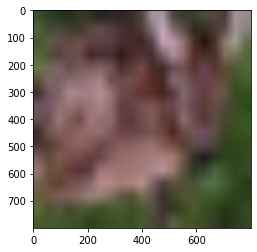

In [10]:
import mindspore.dataset.transforms.c_transforms as c_transforms
import mindspore.dataset.vision.c_transforms as C
import matplotlib.pyplot as plt

cifar10_path = "./datasets/cifar10/train"

# create Cifar10Dataset for reading data
cifar10_dataset = ds.Cifar10Dataset(cifar10_path,num_parallel_workers=4)
transforms = C.RandomResizedCrop((800,800))
# apply the transform to the dataset through dataset.map()
cifar10_dataset = cifar10_dataset.map(operations=transforms,input_columns="image",num_parallel_workers=4)

data = next(cifar10_dataset.create_dict_iterator())
plt.imshow(data["image"].asnumpy())
plt.show()

2. 使用自定义Python函数进行数据增强，数据增强时采用多进程优化方案，开启了4个进程并发完成任务。

In [11]:
def generator_func():
    for i in range(5):
        yield (np.array([i,i+1,i+2,i+3,i+4]),)

ds3 = ds.GeneratorDataset(source=generator_func,column_names=["data"])
print("before map:")
for data in ds3.create_dict_iterator():
    print(data["data"])

func = lambda x:x**2
ds4 = ds3.map(operations=func,input_columns="data",python_multiprocessing=True,num_parallel_workers=4)
print("after map:")
for data in ds4.create_dict_iterator():
    print(data["data"])

before map:
[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
after map:
[ 0  1  4  9 16]
[ 1  4  9 16 25]
[ 4  9 16 25 36]
[ 9 16 25 36 49]
[16 25 36 49 64]


## 操作系统性能优化

由于数据处理是在host端进行，那么机器或者操作系统本身的一些配置会对数据处理存在影响，主要有存储、NUMA架构、CPU（计算资源）几个方面。

1. 存储

    当数据集较大时，推荐使用固态硬盘对数据进行存储，能够减少存储I/O对数据处理的影响。

> 一般地，当数据集被加载之后，就会缓存在操作系统的page cache中，在一定程度上降低了存储开销，加快了后续epoch的数据读取。

2. NUMA架构

    非一致性内存架构(Non-uniform Memory Architecture)是为了解决传统的对称多处理(Symmetric Multi-processor)系统中的可扩展性问题而诞生的。NUMA系统拥有多条内存总线，于是将几个处理器通过内存总线与一块内存相连构成一个组，这样整个庞大的系统就可以被分为若干个组，这个组的概念在NUMA系统中被称为节点(node)。处于该节点中的内存被称为本地内存(local memory)，处于其他节点中的内存对于该组而言被称为外部内存(foreign memory)。因此每个节点访问本地内存和访问其他节点的外部内存的延迟是不相同的，在数据处理的过程中需要尽可能避免这一情况的发生。一般我们可以使用以下命令进行进程与node节点的绑定：

```bash
numactl --cpubind=0 --membind=0 python train.py
```

3. CPU（计算资源）  

CPU对于数据处理的影响主要是计算资源的分配和CPU频率的设置两个方面。

- 计算资源的分配

    当我们进行分布式训练时，一台设备机器上会启动多个训练进程，而这些训练进程会通过操作系统本身的策略进行计算资源的分配与抢占，当进程较多时，可能会由于计算资源的竞争而导致数据处理性能的下降，因此这时需要进行人工分配计算资源，避免各个进程的计算资源竞争。

```bash
numactl --cpubind=0 python train.py
```

或

```bash
taskset -c 0-15 python train.py
```

> `numactl`的方式较为粗粒度，直接指定`numa node id`，而`taskset`的方式是细粒度的，它能够直接指定`numa node`上的`cpu core`，其中0-15表示的`core id`从0到15。

- CPU频率设置

    要想充分发挥host端CPU的最大算力，CPU频率的设置至关重要。一般地，linux内核支持调节CPU主频，降低功耗，已到达节能的效果。通过选择系统空闲状态不同的电源管理策略，可以实现不同程度降低服务器功耗。但是，更低的功耗策略意味着CPU唤醒更慢对性能影响更大。因此如果发现CPU模式为conservative或者powersave，可以使用cpupower设置CPU Performance模式，对数据处理的性能提升有非常大的效果。  

```bash
cpupower frequency-set -g performance
```

## 性能优化方案总结

### 多线程优化方案

在数据pipeline过程中，相关算子一般都有线程数设置参数，来提升处理并发度，提升性能，例如：

- 在数据加载的过程中，内置数据加载类有`num_parallel_workers`参数用来设置线程数。

- 在数据增强的过程中，`map`函数有`num_parallel_workers`参数用来设置线程数。

- 在Batch的过程中，`batch`函数有`num_parallel_workers`参数用来设置线程数。

具体内容请参考[内置加载算子](https://www.mindspore.cn/doc/api_python/zh-CN/master/mindspore/mindspore.dataset.html)。

### 多进程优化方案

数据处理中Python实现的算子均支持多进程的模式，例如：

- `GeneratorDataset`这个类默认是多进程模式，它的`num_parallel_workers`参数表示的是开启的进程数，默认为1，具体内容请参考[GeneratorDataset](https://www.mindspore.cn/doc/api_python/zh-CN/master/mindspore/dataset/mindspore.dataset.GeneratorDataset.html)。

- 如果使用Python自定义函数或者`py_transforms`模块进行数据增强的时候，当`map`函数的参数`python_multiprocessing`设置为True时，此时参数`num_parallel_workers`表示的是进程数，参数`python_multiprocessing`默认为False，此时参数`num_parallel_workers`表示的是线程数，具体的内容请参考[内置加载算子](https://www.mindspore.cn/doc/api_python/zh-CN/master/mindspore/mindspore.dataset.html)。

### Compose优化方案

Map算子可以接收Tensor算子列表，并将按照顺序应用所有的这些算子，与为每个Tensor算子使用的Map算子相比，此类“胖Map算子”可以获得更好的性能，如图所示：

![compose](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/advanced_use/images/compose.png)

### 算子融合优化方案

提供某些融合算子，这些算子将两个或多个算子的功能聚合到一个算子中。具体内容请参考[数据增强算子](https://www.mindspore.cn/doc/api_python/zh-CN/master/mindspore/mindspore.dataset.vision.html)，与它们各自组件的流水线相比，这种融合算子提供了更好的性能。如图所示：

![operator-fusion](https://gitee.com/mindspore/docs/raw/master/tutorials/training/source_zh_cn/advanced_use/images/operator_fusion.png)

### 操作系统优化方案

- 使用固态硬盘进行数据存储。

- 将进程与node节点绑定。

- 人工分配更多的计算资源。

- 提高CPU运算频率。

## 参考文献

[1] Alex Krizhevsky. [Learning Multiple Layers of Features from Tiny Images](http://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf).